<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV  
from sklearn.model_selection import TimeSeriesSplit
import math

from numpy.random import RandomState

In [2]:
RANDOM_STATE = RandomState(12345) 

In [3]:
if os.path.exists('taxi.csv'):
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
elif os.path.exists('/datasets/taxi.csv'):
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [4]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Сделаем ресемплирование по одному часу

In [5]:
data = data.resample('1H').sum()

In [6]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


В данных присутсвует информация о заказах за период с марта по август включительно.

Проверим одинаковое ли количество данных за каждый день

In [8]:
data.resample('1D').count().value_counts()

num_orders
24            184
dtype: int64

В каждом дне присутсвуют значения за каждый час

<AxesSubplot:xlabel='datetime'>

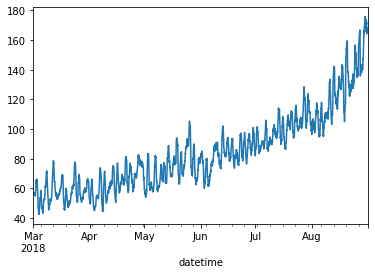

In [9]:
decomposed = seasonal_decompose(data) 
decomposed.trend.plot()

Плавное увелечение количества заказов такси каждый месяц - это тренд

Посмотрим график заказов за один день. Для этого создадим столбец "hours" и сгруппируем по нему. При группировки количества заказов возьмутся как среднее число. 

In [10]:
buf = data.copy()

In [11]:
buf['hours'] = buf.index.hour

In [12]:
buf = buf[['hours', 'num_orders']]

<AxesSubplot:xlabel='hours'>

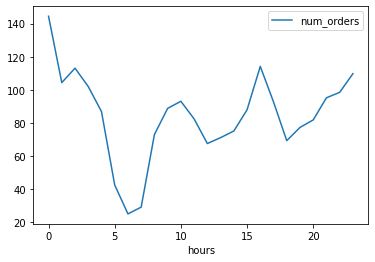

In [13]:
buf.groupby(by='hours').mean().plot()

Получается, что в среднем пиковые часы для заказа такси это примерно 10 утра, 3 часа дня и рост спроса к полуночи.

Часовая (за 2 дня) и дневная (за 2 недели) сезонность выглядит следующим образом:


In [14]:
buf = data.resample('1D').sum()
buf = buf['2018-08-13':'2018-08-26']
buf['weekday'] = buf.index.day_name()
buf

,num_orders,weekday
datetime,,
2018-08-13,3356,Monday
2018-08-14,2868,Tuesday
2018-08-15,2943,Wednesday
2018-08-16,3087,Thursday
2018-08-17,3244,Friday
2018-08-18,3033,Saturday
2018-08-19,2801,Sunday
2018-08-20,3826,Monday
2018-08-21,3077,Tuesday


<AxesSubplot:xlabel='datetime'>

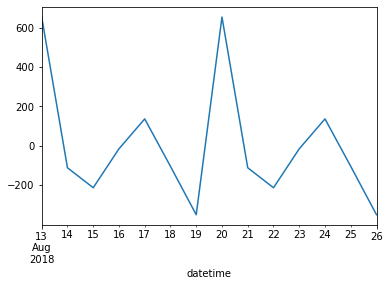

In [15]:
decomposed = seasonal_decompose(buf['2018-08-13':'2018-08-26']['num_orders']) 
decomposed.seasonal.plot()

Заметим, что в понедельник (13 и 20 число) - самый высокий спрос на такси. К среде он падает и затем плавно растет к пятнице (она является вторым, менее высоким пиком). К воскресенью спрос также уменьшается.

<AxesSubplot:xlabel='datetime'>

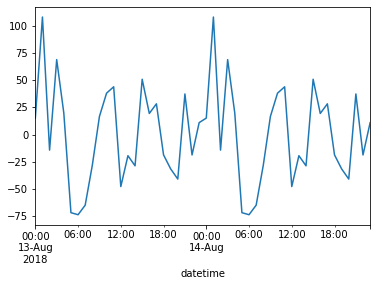

In [16]:
buf = data.resample('1H').sum()
decomposed = seasonal_decompose(buf['2018-08-13':'2018-08-14']) 
decomposed.seasonal.plot()


Из данного графика можно выделить примерные промежутки времени, когда спрос наиболее высок: 8:00-11:00, 14:00-16:00, 20:00-02:00.

## Обучение

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['hours'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [18]:
make_features(data, 24, 1)

Удалим 1 строку, так как в ней из-за сдвигов отсутвуются значения

In [19]:
data.drop(index=data.index[0], axis=0 , inplace= True )

In [20]:
data

,num_orders,hours,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0
2018-03-01 05:00:00,6,5,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,207.0
2018-08-31 20:00:00,154,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,136.0
2018-08-31 21:00:00,159,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,154.0


Создадим фунцию для разделения данных, так как для моделей RandomForestRegressor и DecisionTreeRegressor нужно будет избавиться от строк со значениями None.

In [21]:
def get_features_target(drop=False):
        if drop == False:
            train, test = train_test_split(data, test_size=0.1, random_state=RANDOM_STATE, shuffle=False) 
        else:
            train, test = train_test_split(data, test_size=0.1, random_state=RANDOM_STATE, shuffle=False) 
            train = train.dropna() 
        return train.drop('num_orders', axis = 1), test.drop('num_orders', axis = 1),  train['num_orders'],  test['num_orders']

Функция создания модели и подбора гиперпараметров.

    Далее подбор гиперпараметров для каждой модели был произведен с помощью гридсерч.

In [22]:
def model_param(name_model, list_iter, f_train, t_train):
    best_rmse = 0
    best_tree_number = None
    best_depth = None
    best_learning_rate = None
    best_rmse = None
    my_cv=TimeSeriesSplit(n_splits=8).split(features_train)
    if name_model == 'LightGBM2':
            model = LGBMRegressor(random_state=RANDOM_STATE, verbose_eval=False)
            clf  = GridSearchCV(estimator=model, param_grid = list_iter, cv=my_cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
            #fit_params = {'eval_set':[(f_valid, t_valid)], 'eval_metric':["rmse"],  'early_stopping_rounds':5}
            clf.fit(f_train, t_train)
            print(-clf.best_score_)
            print(clf.best_params_ )
            best_tree_number = clf.best_params_['n_estimators']
            best_depth = math.log2(clf.best_params_['num_leaves'])
            best_learning_rate = clf.best_params_['learning_rate']
    elif name_model == 'CatBoostRegressor2':
            model = CatBoostRegressor(random_state=12345, verbose=False)
            clf  = GridSearchCV(estimator=model, param_grid = list_iter, cv=my_cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
            clf.fit(f_train, t_train)
            print(-clf.best_score_ )
            print(clf.best_estimator_ )
            best_tree_number = clf.best_params_['n_estimators']
            best_depth = clf.best_params_['depth']
            best_learning_rate = clf.best_params_['learning_rate']
    elif name_model == 'RandomForestRegressor2':
            model = RandomForestRegressor(random_state=RANDOM_STATE)
            clf  = GridSearchCV(estimator=model, param_grid = list_iter, cv=my_cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
            clf.fit(f_train, t_train)
            print(-clf.best_score_ )
            print(clf.best_estimator_ )
            best_tree_number = clf.best_params_['n_estimators']
            best_depth =clf.best_params_['max_depth']
    elif name_model == 'DecisionTreeRegressor2':
            model = DecisionTreeRegressor(random_state=RANDOM_STATE)
            clf  = GridSearchCV(estimator=model, param_grid = list_iter, cv=my_cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
            clf.fit(f_train, t_train)
            print(-clf.best_score_ )
            print(clf.best_estimator_ )
            best_depth = clf.best_params_['max_depth']
    #predictions = clf.predict(f_valid)
    best_rmse = -clf.best_score_
    print("------------------Итог------------------")
    print("Лучшая модель по rmse:", best_rmse, "n_estimators =", best_tree_number,'learning_rate',best_learning_rate,'depth',best_depth)
    return [best_rmse, best_tree_number,best_learning_rate,best_depth]
    

     

In [23]:
dict_model = {}

In [24]:
features_train, features_test, target_train, target_test = get_features_target()

dict_model['LightGBM2'] = model_param('LightGBM2', {'n_estimators':range(100, 500, 100), 'num_leaves':[2**1, 2**2, 2**3, 2**4, 2**5],'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0]}, features_train, target_train)

[LightGBM] [Warning] Unknown parameter: verbose_eval
24.105020490824423
{'learning_rate': 0.1, 'n_estimators': 400, 'num_leaves': 4}
------------------Итог------------------
Лучшая модель по rmse: 24.105020490824423 n_estimators = 400 learning_rate 0.1 depth 2.0


In [25]:
features_train, features_test, target_train, target_test = get_features_target(drop=True)
dict_model['RandomForestRegressor2'] = model_param('RandomForestRegressor2',{'n_estimators':[80,85,90,95,100,150,200,250, 300], 'max_depth':range(2, 7, 1)},features_train, target_train)

25.69346628642689
RandomForestRegressor(max_depth=6, n_estimators=150,
                      random_state=RandomState(MT19937) at 0x241641F3E40)
------------------Итог------------------
Лучшая модель по rmse: 25.69346628642689 n_estimators = 150 learning_rate None depth 6


In [26]:
features_train, features_test, target_train, target_test = get_features_target(drop=True)
dict_model['DecisionTreeRegressor2'] = model_param('DecisionTreeRegressor2', {'max_depth':range(1, 9, 1)},features_train, target_train)

29.462613776614525
DecisionTreeRegressor(max_depth=6,
                      random_state=RandomState(MT19937) at 0x241644B5840)
------------------Итог------------------
Лучшая модель по rmse: 29.462613776614525 n_estimators = None learning_rate None depth 6


In [27]:
features_train, features_test, target_train, target_test = get_features_target()
dict_model['CatBoostRegressor2'] = model_param('CatBoostRegressor2', {'n_estimators':range(100, 500, 100), 'depth':range(1, 6, 1),'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0]}, features_train, target_train)

23.6604689670318
------------------Итог------------------
Лучшая модель по rmse: 23.6604689670318 n_estimators = 300 learning_rate 0.1 depth 5


In [28]:
for key, value in dict_model.items():
    print(key, 'rmse:', value[0], 'n_estimators:', value[1], 'learning_rate:', value[2], 'depth:', value[3])

LightGBM2 rmse: 24.105020490824423 n_estimators: 400 learning_rate: 0.1 depth: 2.0
RandomForestRegressor2 rmse: 25.69346628642689 n_estimators: 150 learning_rate: None depth: 6
DecisionTreeRegressor2 rmse: 29.462613776614525 n_estimators: None learning_rate: None depth: 6
CatBoostRegressor2 rmse: 23.6604689670318 n_estimators: 300 learning_rate: 0.1 depth: 5


Лучшие значения по метрике rmse показали модели CatBoostRegressor и LightGBM, так как первая модель немного превосходит вторую, то лучшей выберем ее.

## Тестирование

Итого:
лучшая модель - CatBoostRegressor с гиперпараметрами:

n_estimators: 300 learning_rate: 0.1 depth: 5


In [29]:
features_train, features_test, target_train, target_test = get_features_target()


In [30]:
model = CatBoostRegressor(n_estimators=300, learning_rate=0.1, random_state=12345, depth=5)
model.fit(features_train, target_train, verbose=50)

0:	learn: 36.9802028	total: 4.03ms	remaining: 1.21s
50:	learn: 22.5945876	total: 169ms	remaining: 824ms
100:	learn: 20.5441002	total: 326ms	remaining: 641ms
150:	learn: 18.6863007	total: 484ms	remaining: 477ms
200:	learn: 17.4376624	total: 640ms	remaining: 315ms
250:	learn: 16.4896666	total: 791ms	remaining: 154ms
299:	learn: 15.6877038	total: 940ms	remaining: 0us


In [31]:
predictions = model.predict(features_test)

In [32]:
print(mean_squared_error(target_test, predictions)**0.5)

40.47619482204827


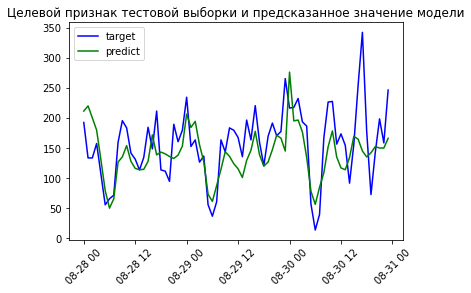

In [33]:
plt.plot(target_test['2018-08-28':'2018-08-30'], 'b-',
         pd.DataFrame(data=predictions, index=target_test.index)['2018-08-28':'2018-08-30'], 'g-')
plt.legend(['target','predict'])
plt.title('Целевой признак тестовой выборки и предсказанное значение модели')
plt.xticks(rotation=45)
plt.show()


В данной работе было проведено исследование данных о количестве заказов такси за несколько месяцев и построена модель для предсказания пиковых часов заказов такси. Для нахождения лучшей модели были сравнены 4 модели, две из которых построены на градиентом бустинге, а две другие основанны на деревьях решений. В связи с самым высоким показателем метрики качества rmse, была выбрана модель CatBoostRegressor. Данная модель показала значение rmse = 40.47619482204827на тестовой выборке. 

При сравнении графиков реальных значений тестовой выборки и предсказанных значений можно заметить, что графики имеют примерно одинаковую структуру т.е. наша модель неплохо описывает перепады (повышения и уменьшения спроса на такси), но делает это немного более сглажено по сравнению с графиком реальных значений. Единственной неточностью для модели яляется резкий скачок заказов, его она предсказала не очень точно.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48